In [43]:
%matplotlib inline
import warnings
import itertools
warnings.simplefilter('ignore')

import pyart
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm

In [44]:
def compute_phase_space(x_in, y_in, x_out, y_out, arr):
    dy = y_out.max() / len(y_out)
    dx = x_out.max() / len(x_out)
    ny, nx = len(y_out), len(x_out)
    phase = np.zeros((ny, nx)) + np.NaN
    
    if x_in.shape != y_in.shape or x_in.shape != arr.shape:
        raise ValueError('Wrong dimensions.')
    
    for j in range(ny):
        for i in range(nx):
            pos = ((x_in >= x_out[i] - dx / 2) &
                   (x_in < x_out[i] + dx / 2) &
                   (y_in >= y_out[j] - dy / 2) &
                   (y_in < y_out[j] + dy / 2))
            
            if np.sum(pos) == 0:
                continue
            
            phase[j, i] = np.nanmean(arr[pos])
            
    return np.ma.masked_invalid(phase)

In [45]:
def get_count(xarea, ycell, mydata, area, cellnb):
    X, Y = np.meshgrid(xarea, ycell)
    
    dy = ycell.max() / len(ycell)
    dx = xarea.max() / len(xarea)
    rslt = np.zeros_like(X)
    
    for yidx, xidx in itertools.product(range(len(ycell)), range(len(xarea))):        
        pos = ((area >= xarea[xidx] - dx / 2) &
              (area < xarea[xidx] + dx / 2) &
              (cellnb >= ycell[yidx] - dy / 2) & 
              (cellnb < ycell[yidx] + dy / 2))
        if np.sum(~np.isnan(mydata[pos])) == 0:
            continue

        rslt[yidx, xidx] = np.sum(~np.isnan(mydata[pos]))

    return np.ma.masked_equal(rslt, 0)

In [46]:
dataset = xr.open_dataset('data/Darwin_large_convective_scales_timeseries.nc')

In [47]:
nb_cells = dataset.number.values
mean_area_convective_cells = dataset.area.values
convective_area_fraction = dataset.cafe.values
conv_rain_intensity = dataset.conv_rain_intensity.values
conv_rain_over_domain = dataset.conv_rain_over_domain.values

In [48]:
ycell = np.linspace(0, 80, 40)
xarea = np.linspace(0, 600, 66)
X, Y = np.meshgrid(xarea, ycell)

In [49]:
caf = 100 * compute_phase_space(mean_area_convective_cells, nb_cells, xarea, ycell, convective_area_fraction)
convective_rain_intensity = compute_phase_space(mean_area_convective_cells, nb_cells, xarea, ycell, conv_rain_intensity)
convective_rain_domain = compute_phase_space(mean_area_convective_cells, nb_cells, xarea, ycell, conv_rain_over_domain)

In [50]:
count = get_count(xarea, ycell, convective_area_fraction, mean_area_convective_cells, nb_cells)

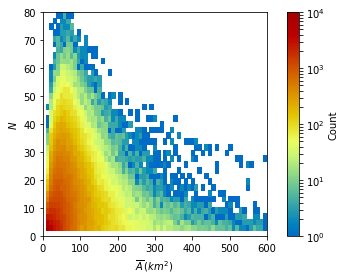

In [51]:
fig, ax = plt.subplots(1, 1)

im1 = ax.pcolormesh( xarea, ycell, count, norm=LogNorm(1, 1e4), cmap='pyart_HomeyerRainbow')
cbar = plt.colorbar(im1, ax=ax)
cbar.set_label('Count')
ax.set_ylabel('$N$')
ax.set_xlabel(r'$\overline{A}\,(km^2)$')
ax.set_aspect(7.5)
ax.set_xlim(0, 600)
ax.set_ylim(0, 80)
fig.tight_layout()
plt.show()

In [52]:
cutoff = 6
caf = np.ma.masked_where(count < cutoff, caf)
convective_rain_intensity = np.ma.masked_where(count < cutoff, convective_rain_intensity)
convective_rain_domain = np.ma.masked_where(count < cutoff, convective_rain_domain)

In [53]:
perc = lambda x: [np.percentile(x[~x.mask], e) for e in [25, 50, 75]]

In [54]:
hist, xe, ye = np.histogram2d(100 * convective_area_fraction.flatten(), conv_rain_over_domain.flatten(), range=[[0, 15], [0, 4]], bins=40)
histm = np.ma.masked_equal(hist, 0)

x, y = 100 * convective_area_fraction.flatten(), conv_rain_over_domain.flatten(),
pos = np.isnan(x) | np.isnan(y)
rpearson = np.corrcoef(x[~pos], y[~pos])[0][1]

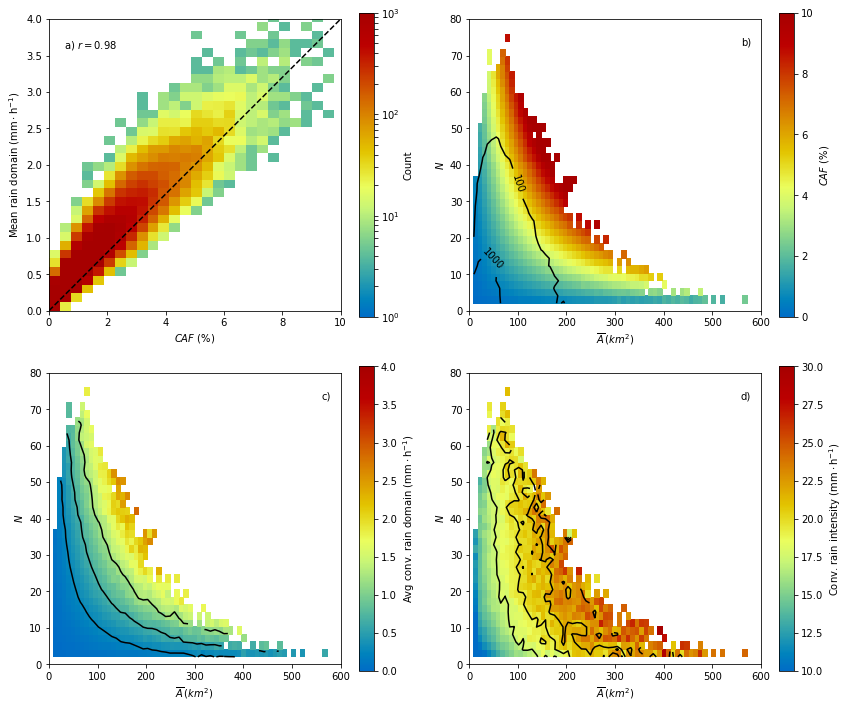

In [55]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10), sharex=False)
ax = ax.ravel()

im0 = ax[0].imshow(np.ma.masked_less(histm, 4), norm=LogNorm(1, 1e3), extent=[0, 15, 0, 4 * 1.2], origin='ij', aspect='auto', cmap='pyart_HomeyerRainbow')
cbar = plt.colorbar(im0, ax=ax[0])
cbar.set_label('Count')
ax[0].plot([0, 10], [0, 4.0], 'k--')    

im1 = ax[1].pcolormesh(xarea, ycell, caf, vmin=0, vmax=10, cmap='pyart_HomeyerRainbow')
CS = ax[1].contour(xarea, ycell, count, levels=[100, 1000], colors='k')
CS.levels = [str(int(val)) for val in CS.levels]
ax[1].clabel(CS, CS.levels, inline=True, fontsize=10)

cbar = plt.colorbar(im1, ax=ax[1])
cbar.set_label('$CAF$ (%)')

im = ax[2].pcolormesh(xarea, ycell, 1.2* convective_rain_domain, vmin=0, vmax=4, cmap='pyart_HomeyerRainbow')
ax[2].contour(xarea, ycell, convective_rain_domain, levels=perc(convective_rain_domain), colors='k')
cbar = plt.colorbar(im, ax=ax[2])
cbar.set_label('Avg conv. rain domain $\\mathrm{(mm\\cdot h^{-1})}$')

im = ax[3].pcolormesh(xarea, ycell, 1.2*convective_rain_intensity, vmin=10, vmax=30, cmap='pyart_HomeyerRainbow')
ax[3].contour(xarea, ycell, convective_rain_intensity, levels=perc(convective_rain_intensity), colors='k')
cbar = plt.colorbar(im, ax=ax[3])
cbar.set_label('Conv. rain intensity $\\mathrm{(mm\\cdot h^{-1})}$')

ax[0].set_ylabel('Mean rain domain $\\mathrm{(mm\\cdot h^{-1})}$')
ax[0].set_xlabel('$CAF$ (%)')

ax[0].set_aspect(10 / 4)
ax[0].set_xlim(0, 10)
ax[0].set_ylim(0, 4)
for e in range(1, 4):
    ax[e].set_aspect(7.5)
    ax[e].set_xlim(0, 600)
    ax[e].set_ylim(0, 80)
    ax[e].set_ylabel('$N$')
    ax[e].set_xlabel(r'$\overline{A}\,(km^2)$')

ax[0].text(0.5, 3.6, f'a) $r=0.98$', ha='left', backgroundcolor='w')
ax[1].text(580, 75, 'b)', va='top', ha='right')
ax[2].text(580, 75, 'c)', va='top', ha='right')
ax[3].text(580, 75, 'd)', va='top', ha='right')

fig.tight_layout()
plt.show()